In [1]:
import pandas as pd

## BERT

In [5]:
import torch
from transformers import BertModel, BertTokenizer

In [2]:
train_df = pd.read_csv('data/user_concat_text_10_train.csv', sep=';')

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_embedding(input_text):
    # Tokenize input text
    input_ids = tokenizer.encode_plus(input_text, 
                                      add_special_tokens=True, 
                                      return_tensors="pt", 
                                      truncation=True,
                                      max_length=512,
                                      padding='max_length')  # Adjust max_length
    # Move inputs to GPU
    input_ids = input_ids.to(device)
    with torch.no_grad():
        # Move model to GPU
        model.to(device)
        outputs = model(**input_ids)  # Pass the tokenized inputs as keyword arguments
        embeddings = outputs.last_hidden_state  # Extract the embeddings
    return embeddings

In [9]:
generate_embedding('We loved this place and are sad that it is closed')

tensor([[[-0.0280, -0.0087,  0.3377,  ...,  0.0632,  0.6283,  0.0244],
         [ 0.4234, -0.1273, -0.4582,  ..., -0.3916,  1.2081, -0.4115],
         [ 1.0119,  0.3709,  0.6229,  ..., -0.0625,  0.3075, -0.4693],
         ...,
         [ 0.1157, -0.1634,  0.4915,  ...,  0.3386,  0.2893, -0.6721],
         [ 0.5154,  0.0806,  0.5953,  ...,  0.3369,  0.1235, -0.3815],
         [ 0.0180, -0.3310,  0.6013,  ...,  0.4107,  0.2971, -0.4481]]],
       device='cuda:0')

In [10]:
device

device(type='cuda')

In [ ]:
# Apply the generate_embedding function to the 'text' column
train_df['bert_embedding'] = train_df['text'].apply(generate_embedding)

# Move DataFrame to CPU for further processing if needed
# train_df = train_df.cpu()

In [21]:
train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.to('cpu').numpy() if isinstance(x, torch.Tensor) else x)

In [28]:
train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.reshape(512, 768))

In [29]:
train_df.head()

,user_id,text,bert_embedding
0,1.040754e+20,"Good food, good people.\nIt's McDonald's. My f...","[[-0.2526437, -0.4397369, 0.45666978, 0.095691..."
1,1.029652e+20,Authentic Tuscany cuisine. Great atmosphere ex...,"[[-0.22569536, 0.06812792, 0.31493652, 0.11971..."
2,1.009114e+20,We love Nippon Grill and we were grateful to b...,"[[0.22323227, -0.17345627, 0.2356291, -0.08483..."
3,1.119671e+20,"A must go if you're in downtown Lowell! Staff,...","[[-0.4919597, -0.27820456, 0.16277456, -0.4657..."
4,1.136804e+20,Great freakin' Q at a reasonable price. Love t...,"[[0.023719942, -0.09157198, 0.47261178, -0.045..."


In [33]:
train_df.to_csv('data/user_concat_text_10_train.csv', sep=';', index=False)

## Find Similar Users

In [30]:
import numpy as np
import importlib
import utility
importlib.reload(utility)
from utility import get_similar_users_avg_rating, merge_df

In [3]:
df_filtered = pd.read_csv("data/english_reviews.csv")

In [8]:
# Count the number of comments per gmap_id
comment_counts = df_filtered['gmap_id'].value_counts().reset_index()
comment_counts.columns = ['gmap_id', 'comment_count']

In [9]:
df_filtered = df_filtered.merge(comment_counts, on='gmap_id', how='left')
df_filtered.to_csv("data/english_reviews.csv", index=False)

In [6]:
get_similar_users_avg_rating(train_df, df_filtered, '1.1803866805367366e+20','0x89e3706a62ba248f:0xdd2878d145d53400')

In [23]:
df_cleaned = merge_df(df_filtered)

/Users/yuqinbailey/ds2/Restaurant-Rec-Google-Reviews/utility.py:40: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


In [26]:
df_cleaned.dtypes

user_id            object
gmap_id            object
text               object
rating              int64
comment_count       int64
name_y             object
latitude          float64
longitude         float64
num_of_reviews      int64
price              object
avg_rating        float64
dtype: object

In [31]:
df_cleaned['bert_rating'] = df_cleaned.apply(lambda row: get_similar_users_avg_rating(
    train_df, df_filtered, row['user_id'], row['gmap_id']), axis=1)

# Replace None with pd.nan in 'bert_rating' column
df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)

/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_5326/325559367.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['bert_rating'].replace({None: pd.NA}, inplace=True)


In [38]:
df_cleaned.to_csv("data/df_cleaned.csv", index=False)

## df_cleaned

**Data:** `df_cleaned`
* English
* emoji removed
* User 10-core
* Restaurant 50-core
* No duplicates
Count: 479,185

In [43]:
df_cleaned = pd.read_csv("data/df_cleaned.csv")

df_cleaned.drop_duplicates(inplace=False)


,user_id,gmap_id,text,rating,comment_count,name_y,latitude,longitude,num_of_reviews,price,avg_rating,bert_rating
0,1.158159e+20,0x89e4123f09765c47:0x7f5c63deb47b41fd,Mobile ordered. Showed up and nobody knew wher...,2,52,Burger King,42.123992,-71.646017,174,$,3.5,NaN
1,1.095395e+20,0x89e4123f09765c47:0x7f5c63deb47b41fd,"Newly renovated, friendly employees, clean and...",5,52,Burger King,42.123992,-71.646017,174,$,3.5,NaN
2,1.010319e+20,0x89e4123f09765c47:0x7f5c63deb47b41fd,Clean new place organized friendly staff,5,52,Burger King,42.123992,-71.646017,174,$,3.5,NaN
3,1.110844e+20,0x89e4123f09765c47:0x7f5c63deb47b41fd,Very fast delivery and nice place,5,52,Burger King,42.123992,-71.646017,174,$,3.5,NaN
4,1.182766e+20,0x89e4123f09765c47:0x7f5c63deb47b41fd,Was nice to see the Burger King finally opened...,2,52,Burger King,42.123992,-71.646017,174,$,3.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
479185,1.158547e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,Has the best shrimp,5,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4,NaN
479186,1.017955e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,"Good food, sword fish is the best",4,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4,NaN
479187,1.101792e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,The chowder actually is exceptionally delicious.,5,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4,NaN
479188,1.052239e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,"(Translated by Google) Nice service, great ser...",5,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4,NaN


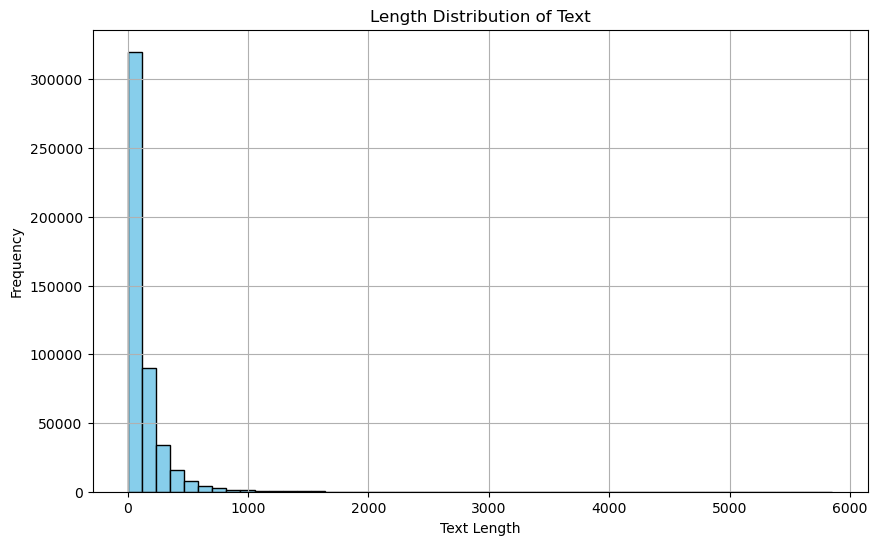

In [44]:
import matplotlib.pyplot as plt

# Calculate the length of each text
text_lengths = df_cleaned['text'].apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Length Distribution of Text')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [45]:
# Calculate the number of comments longer than 100 characters
comments_longer_than_100 = df_cleaned[df_cleaned['text'].str.len() > 512]

# Calculate the percentage of comments longer than 100 characters
percentage_longer_than_100 = (len(comments_longer_than_100) / len(df_cleaned)) * 100

print(f"Percentage of comments longer than 512 characters: {percentage_longer_than_100:.2f}%")


Percentage of comments longer than 512 characters: 3.42%
